
# smooth clouds, references


### JAH, June 2021

In [1]:
%matplotlib inline
#%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [53]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.ndimage     as ndimg

import clouds.utils      as cu
import clouds.sources    as csources
import clouds.sclouds    as sclouds
import clouds.dclouds    as dclouds
import clouds.pclouds    as plouds
import clouds.testclouds as tclouds

from clouds.pclouds import fig, ax3d, efig, hopts, voxels, scatter

In [9]:
plt.rcParams['image.cmap'] = 'rainbow'

In [10]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue Jun 22 09:32:07 2021


## Edge

  Edge is the area where the modulus of the gradient is maximum in the gradient direction:

  Math condition:
      
   * $L_{vv} = 0$ and $L_{vvv} < 0$, where $L_v$ is the derectional derivate in the gradient direction

  Note: There is a *Sobel* filter in skimage, but only 2D


## A rectangle

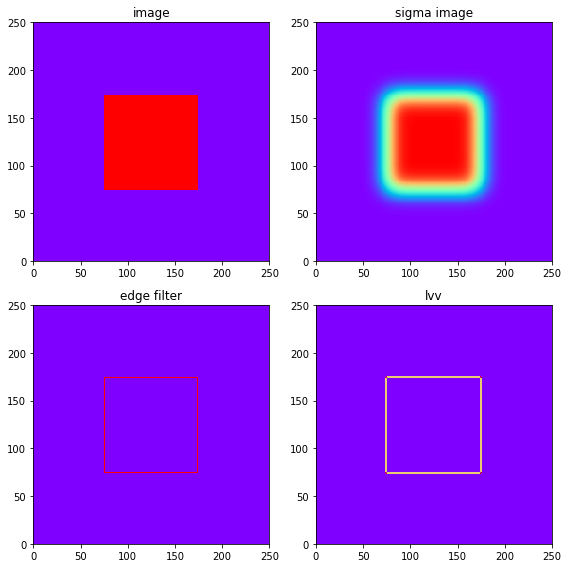

In [18]:
sigma     = 10
img, bins = csources.rectangle();
simg      = ndimg.gaussian_filter(img, sigma)
steps     = [bin[1] - bin[0] for bin in bins]
xfil, lvv = sclouds .edge_filter(img, steps)

fig(2, 2)
plt.subplot(2, 2, 1); voxels( img, bins); plt.title('image');
plt.subplot(2, 2, 2); voxels(simg, bins); plt.title('sigma image');
plt.subplot(2, 2, 3); voxels(xfil, bins); plt.title('edge filter');
plt.subplot(2, 2, 4); voxels(lvv , bins); plt.title('lvv');
efig();

## Ridge

An edge is the region where the gradient has the same direction as the hessian eigen-vector with the largest eigenvalue, and the other eigenvalues of the hessian are negative.

   * ${\bf v} = {\bf e}_n $, $|\lambda_i| > |\lambda_j|$ if $i < j$, and $\lambda_i < 0$ for $i = 0, \dots, n-1$

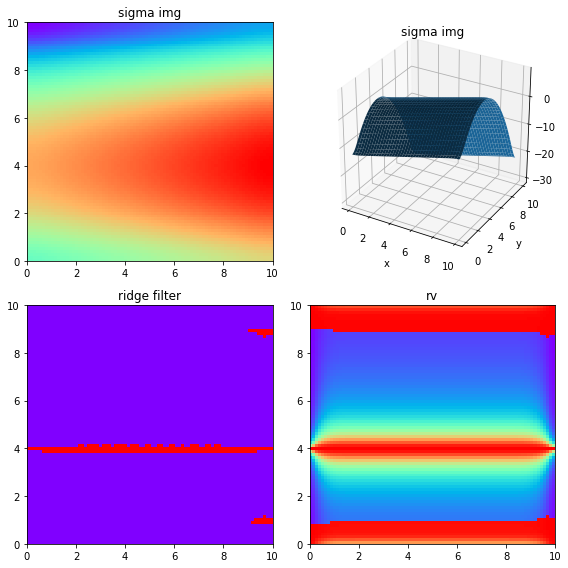

In [45]:
sigma  = 4
y0     = 4
fun    = lambda x : x[0] - (x[1] - y0)**2
ranges = ((0, 10), (0, 10))
nbins  = 81

img, bins = csources.from_function(fun, nbins, ranges)
steps     = [bin[1] - bin[0] for bin in bins]
simg      = ndimg.gaussian_filter(img, sigma)
xmesh     = cu.ut_mesh(bins)

xfil, rv  = sclouds.ridge_filter(simg, steps)


# make a 2D histogram
fig(2, 2)
plt.subplot(2, 2, 1); voxels(simg, bins); plt.title('sigma img')
plt.subplot(2, 2, 2);
ax1 = ax3d(2, 2, 2)
ax1.plot_surface(*xmesh, simg);
plt.xlabel('x'); plt.ylabel('y'); plt.title('sigma img');
plt.subplot(2, 2, 3); voxels(xfil, bins); plt.title('ridge filter');
plt.subplot(2, 2, 4); voxels(rv, bins); plt.title('rv');
efig();

## Blob Filter

A blob is a local extrema of the laplacian (other possibility is the determinant of the hessian)

   * max $\nabla^2 f$

In general the blob has the problem of the scale (the same is valid for ridge and edge).

In order to indenty the scale (size, $\sigma$) of the blob, the normal laplacian (a FoM) is minimized:

   * max $\sigma \nabla^2 f$ 


estimated radius factor  1.7107863825464347 +/- 0.08812443809318929


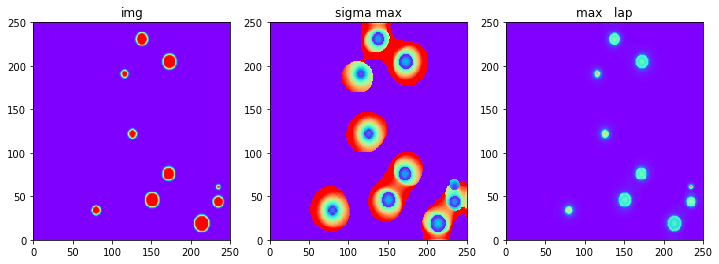

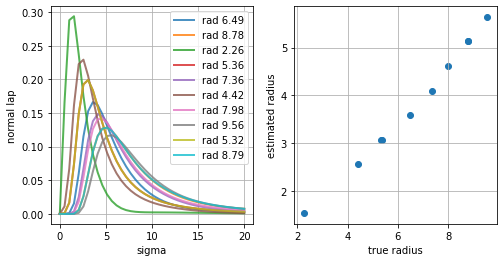

In [46]:
sigma     = 1
npoints   = 10
maxradius = 10

sigmas    = np.linspace(0, 2 * maxradius, 40)
img, indices, radius = csources.disks(npoints = npoints, maxradius = maxradius)
simg                 = ndimg.gaussian_filter(img, sigma) if sigma >0 else img
sigmax, lapmax, laps = sclouds.nlap_scan(simg, sigmas = sigmas, filter = False)

fig(1, 3);
plt.subplot(1, 3, 1); voxels(simg)  ; plt.title('img')
plt.subplot(1, 3, 2); voxels(sigmax); plt.title('sigma max')
plt.subplot(1, 3, 3); voxels(lapmax); plt.title('max   lap')

fig(1, 2);
plt.subplot(1, 2, 1)
nsigmas = laps.shape[0]
for i, index in enumerate(indices):
    xlaps = [laps[(i,) + index] for i in range(nsigmas)]
    plt.plot(sigmas, xlaps, label = 'rad {:4.2f}'.format(radius[i]), alpha = 0.8, lw = 2);
plt.legend();
plt.xlabel('sigma'); plt.ylabel('normal lap'); plt.grid();

plt.subplot(1, 2, 2)
radmu = [sigmax[index] for index in indices]
rat   = np.array(radius)/np.array(radmu)
print('estimated radius factor ', np.mean(rat), '+/-', np.std(rat))
plt.scatter(radius, radmu); plt.grid();
plt.xlabel('true radius'); plt.ylabel('estimated radius');

## Other plots

In [57]:
y0, z0 = 5, 3
fun    = lambda x:  x[0]  - (x[1] - y0)**2  - 0.5 * (x[2] - z0)**2
ranges = 3*((0, 10),)
nbins  = 41

img, bins = csources.from_function(fun, nbins, ranges)
xmesh     = cu.ut_mesh(bins)
steps     = [bin[1] - bin[0] for bin in bins]

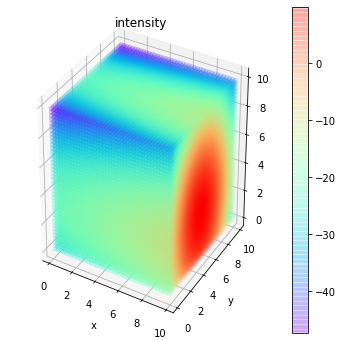

In [58]:
fig = plt.figure(figsize = (6, 6))

def _plot3d(i, var, name, nx, ny):
    ax  = fig.add_subplot(nx, ny, i + 1, projection = '3d')
    p = ax.scatter(*xmesh, '.', c = var.flatten(), alpha = 0.2);
    plt.xlabel('x'); plt.ylabel('y'); plt.title(name); plt.colorbar(p);

counts, _ = np.histogramdd([x.flatten() for x in xmesh], bins, weights = img.flatten())
assert (np.all(counts == img)) # Test the the img is the same ad the histogram


_plot3d(0, img, 'intensity', 1, 1)

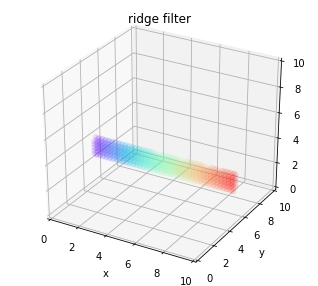

In [62]:
plt.figure(figsize = (12, 5));
cells_select = dclouds.cells_selection
perc     = 10

ax  = plt.subplot(1, 2, 1, projection = '3d');
sel, _ = sclouds.ridge_filter(img, steps, perc)
p = ax.scatter(*cells_select(xmesh, sel), '.', c = img[sel], alpha = 0.1);
ax.set_xlim((bins[0][0], bins[0][-1])); ax.set_ylim((bins[1][0], bins[1][-1]));
ax.set_zlim((bins[2][0], bins[2][-1]))
plt.xlabel('x'); plt.ylabel('y'); plt.title('ridge filter');